In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, QuantileRegressor
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
from sklearn.preprocessing import StandardScaler

In [12]:
data = pd.read_csv('GlobalWeatherRepository.csv')
df = pd.DataFrame(data)
df = df[df['temperature_celsius'] > 0]
df

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.5200,69.1800,Asia/Kabul,1715849100,2024-05-16 13:15,26.6,79.8,Partly Cloudy,...,8.40,26.600,1,1,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,55
1,Albania,Tirana,41.3300,19.8200,Europe/Tirane,1715849100,2024-05-16 10:45,19.0,66.2,Partly cloudy,...,1.10,2.000,1,1,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,55
2,Algeria,Algiers,36.7600,3.0500,Africa/Algiers,1715849100,2024-05-16 09:45,23.0,73.4,Sunny,...,10.40,18.400,1,1,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,55
3,Andorra,Andorra La Vella,42.5000,1.5200,Europe/Andorra,1715849100,2024-05-16 10:45,6.3,43.3,Light drizzle,...,0.70,0.900,1,1,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,55
4,Angola,Luanda,-8.8400,13.2300,Africa/Luanda,1715849100,2024-05-16 09:45,26.0,78.8,Partly cloudy,...,183.40,262.300,5,10,06:12 AM,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32407,Venezuela,Caracas,10.5000,-66.9167,America/Caracas,1730278800,2024-10-30 05:00,18.7,65.6,Partly Cloudy,...,24.42,37.185,2,3,06:18 AM,06:04 PM,04:46 AM,04:53 PM,Waning Crescent,6
32408,Vietnam,Hanoi,21.0333,105.8500,Asia/Bangkok,1730278800,2024-10-30 16:00,26.8,80.3,Partly Cloudy,...,70.30,104.895,4,9,05:58 AM,05:22 PM,03:57 AM,04:00 PM,Waning Crescent,6
32409,Yemen,Sanaa,15.3547,44.2067,Asia/Aden,1730278800,2024-10-30 12:00,21.1,70.0,Sunny,...,26.27,154.290,2,3,05:59 AM,05:35 PM,04:10 AM,04:15 PM,Waning Crescent,6
32410,Zambia,Lusaka,-15.4167,28.2833,Africa/Lusaka,1730278800,2024-10-30 11:00,32.8,91.0,Partly Cloudy,...,24.79,35.705,2,3,05:32 AM,06:10 PM,04:05 AM,04:37 PM,Waning Crescent,6


In [13]:
numeric_df = df.select_dtypes(include=[np.number])
features = list(map(lambda x: x[0],
                        list(filter(lambda x: x[1]>0.1, 
                                    list(sorted({key: abs(value) for key, value in dict(numeric_df.corr()['temperature_celsius']).items()
                                                }.items(), 
                                                key=lambda item: item[1]
                                               )
                                        )
                                   )
                            )
                       )  
                   )
features = [feature for feature in features if feature != 'temperature_celsius']
features = [feature for feature in features if feature != 'temperature_fahrenheit']
features

['air_quality_gb-defra-index',
 'air_quality_PM10',
 'last_updated_epoch',
 'longitude',
 'cloud',
 'air_quality_Ozone',
 'humidity',
 'pressure_mb',
 'pressure_in',
 'uv_index',
 'feels_like_fahrenheit',
 'feels_like_celsius']

In [14]:
y = df['temperature_celsius'].values.reshape(-1, 1)
x = df[features]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [16]:
# Function to evaluate model performance
def evaluate_model(model, x_test, y_test):
    predictions = model.predict(x_test)
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = sqrt(mse)
    r2 = r2_score(y_test, predictions)
    mape = mean_absolute_percentage_error(y_test, predictions)
    return predictions, mae, mse, rmse, r2, mape

In [17]:
results = {}

# 1. Linear Regression
lr = LinearRegression()
lr.fit(x_train_scaled, y_train)
results['Linear Regression'] = evaluate_model(lr, x_test_scaled, y_test)

# 2. Quantile Regression
qr = QuantileRegressor()
qr.fit(x_train_scaled, y_train.ravel())
results['Quantile Regression'] = evaluate_model(qr, x_test_scaled, y_test)

# 3. Ridge Regression
ridge = Ridge()
ridge.fit(x_train_scaled, y_train)
results['Ridge Regression'] = evaluate_model(ridge, x_test_scaled, y_test)

# 4. Lasso Regression
lasso = Lasso()
lasso.fit(x_train_scaled, y_train)
results['Lasso Regression'] = evaluate_model(lasso, x_test_scaled, y_test)

# 5. Elastic Net Regression
en = ElasticNet()
en.fit(x_train_scaled, y_train)
results['Elastic Net Regression'] = evaluate_model(en, x_test_scaled, y_test)

# 6. Principal Component Regression (using PCA + Linear Regression)
pca = PCA(n_components=min(x_train.shape[1], 10))  # Choose optimal components
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)
pcr = LinearRegression()
pcr.fit(x_train_pca, y_train)
results['Principal Component Regression'] = evaluate_model(pcr, x_test_pca, y_test)

# 7. Partial Least Squares Regression
pls = PLSRegression(n_components=min(x_train.shape[1], 10))
pls.fit(x_train_scaled, y_train)
results['Partial Least Squares Regression'] = evaluate_model(pls, x_test_scaled, y_test)

# 8. Support Vector Regression
svr = SVR()
svr.fit(x_train_scaled, y_train.ravel())
results['Support Vector Regression'] = evaluate_model(svr, x_test_scaled, y_test)


In [18]:
# Display results
for model_name, metrics in results.items():
    print(f"{model_name} Results:")
    print(f"MAE: {metrics[1]}")
    print(f"MSE: {metrics[2]}")
    print(f"RMSE: {metrics[3]}")
    print(f"R2: {metrics[4]}")
    print(f"MAPE: {metrics[5]}\n")



Linear Regression Results:
MAE: 1.0374023646834745
MSE: 1.9356117721391397
RMSE: 1.3912626539008153
R2: 0.9623773301534289
MAPE: 0.0525428653576982

Quantile Regression Results:
MAE: 5.416033364226134
MSE: 52.24400988569663
RMSE: 7.228001790653945
R2: -0.015471781936067908
MAPE: 0.4081761590702274

Ridge Regression Results:
MAE: 1.0372347601071252
MSE: 1.935167111106077
RMSE: 1.3911028398742047
R2: 0.9623859730721595
MAPE: 0.05252834494183866

Lasso Regression Results:
MAE: 1.423196798538631
MSE: 3.6717451582424387
RMSE: 1.9161798345255694
R2: 0.9286319406413637
MAPE: 0.08975087217263143

Elastic Net Regression Results:
MAE: 1.6648589560266405
MSE: 4.816470006741897
RMSE: 2.1946457588280386
R2: 0.9063818150427447
MAPE: 0.11845690216756599

Principal Component Regression Results:
MAE: 1.0376120837349834
MSE: 1.9365829640361762
RMSE: 1.3916116426777179
R2: 0.9623584530042888
MAPE: 0.05251720262935632

Partial Least Squares Regression Results:
MAE: 1.0375614539817308
MSE: 1.93656075922650

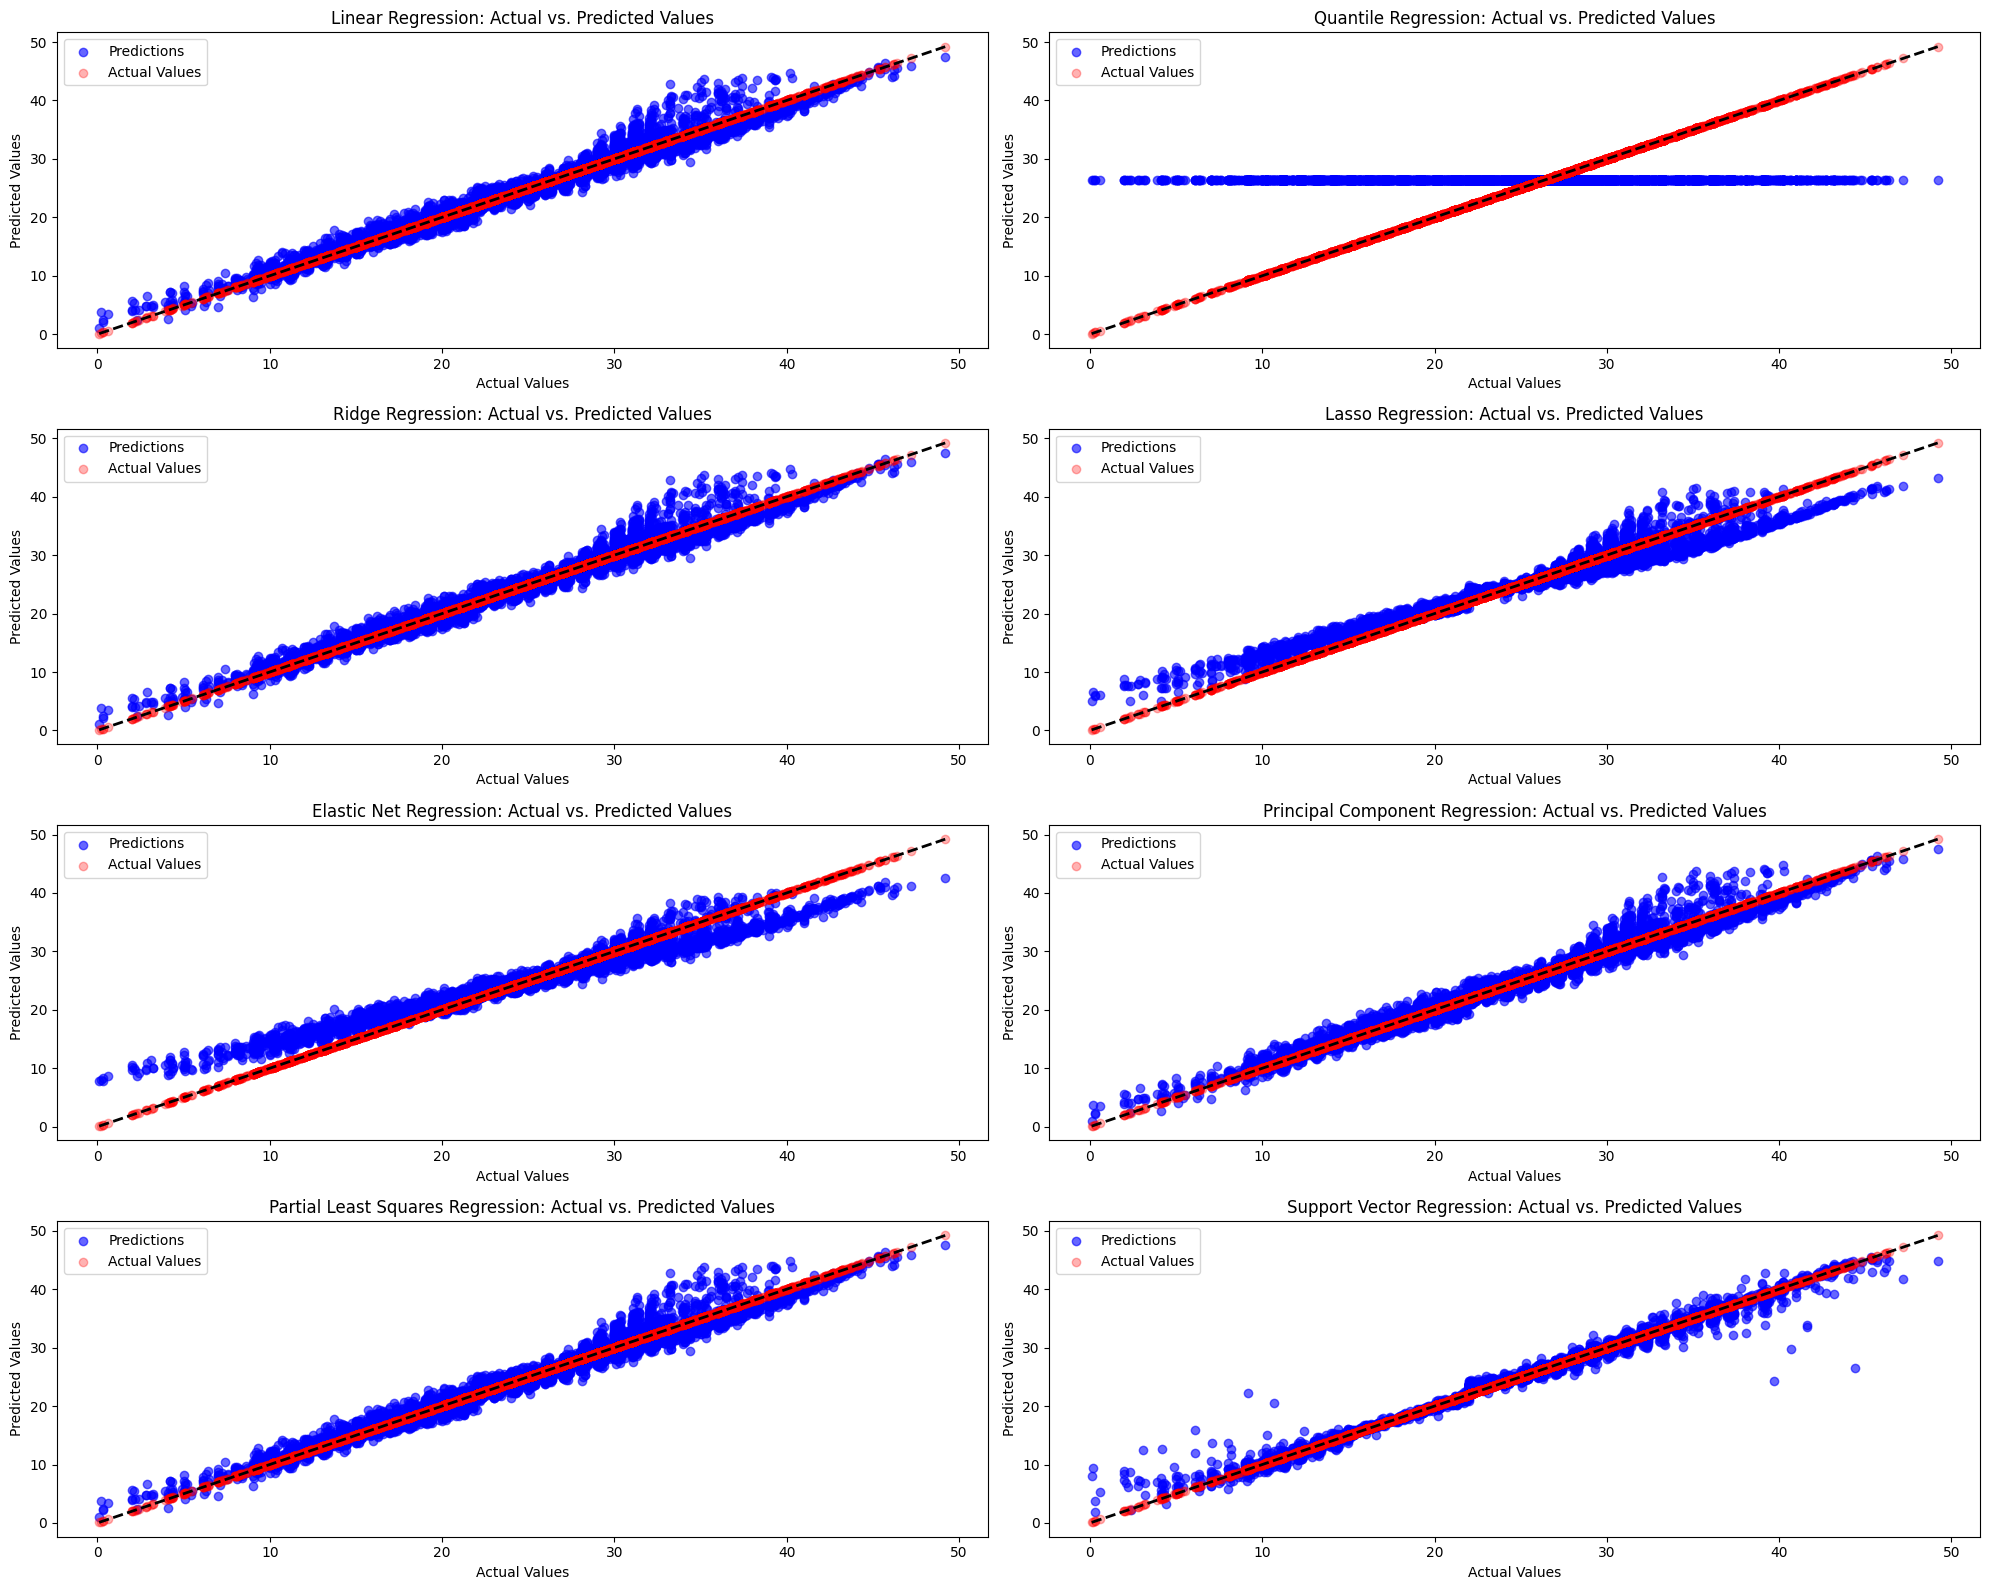

In [19]:
plt.figure(figsize=(20, 16))

for i, (model_name, metrics) in enumerate(results.items()):
    predictions = metrics[0]
    actual = y_test.flatten()
    plt.subplot(4, 2, i + 1)
    plt.scatter(actual, predictions, color='blue', alpha=0.6, label='Predictions')
    plt.scatter(actual, actual, color='red', alpha=0.3, label='Actual Values')
    plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], color='black', linestyle='--', lw=2)
    plt.title(f'{model_name}: Actual vs. Predicted Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()

plt.tight_layout()
plt.show()


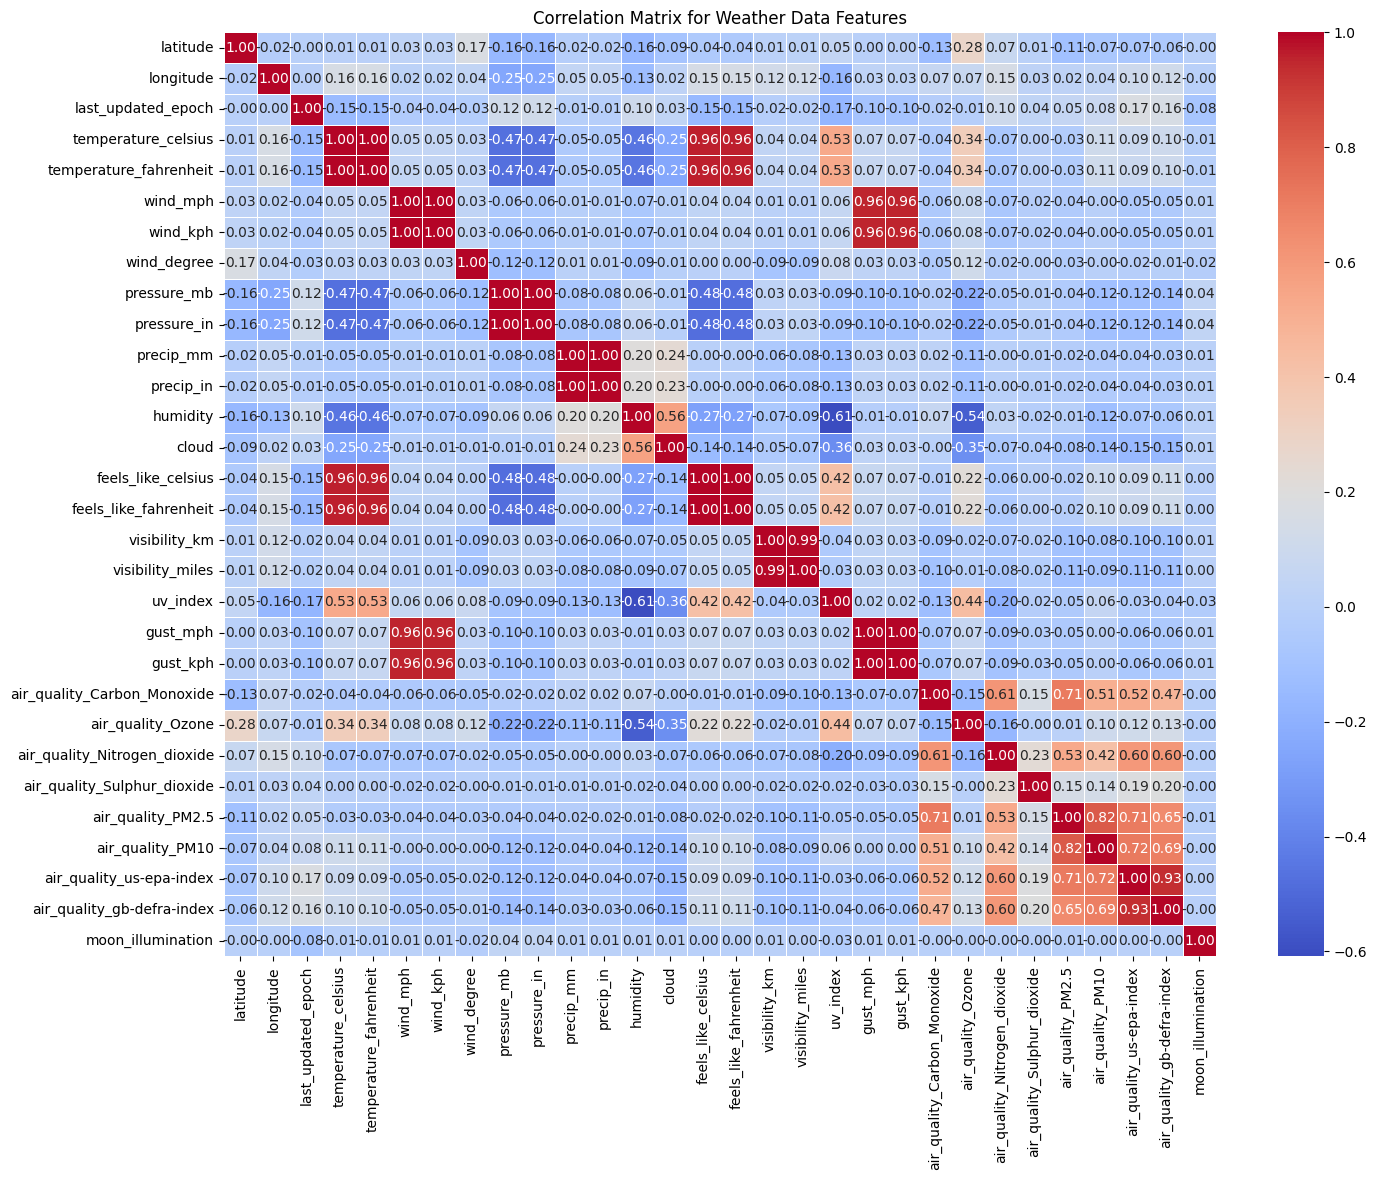

In [20]:
corr_matrix = numeric_df.corr()

# Plotting the correlation matrix
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix for Weather Data Features')
plt.show()
